In [111]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import galois
from mec import make_circle
import seaborn as sns
from scipy.sparse import csr_matrix, csc_matrix, eye

In [248]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [9,6,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[2]
# code = [18,12,1,11,3,2,15,1]
# code = [28,14,26,6,8,7,9,20]
# code = [3,3,3,1,2,3,1,2]

In [249]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [250]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [251]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [252]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

k = 8


In [253]:
As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]

def has_toric_layout1():
    def order(arr):
        for i in range(1, m*ell):
            if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                return i
        return -1
    
    Aorders = [order(As[0]), order(As[1]), order(As[2])]
    Borders = [order(Bs[0]), order(Bs[1]), order(Bs[2])]

    pot_orders = []
    for i, Ao in enumerate(Aorders):
        for j, Bo in enumerate(Borders):
            if (Ao*Bo == m*ell):
                pot_orders.append((Ao,Bo,i,j))
    return pot_orders

has_toric_layout1()

[(6, 9, 0, 1), (6, 9, 1, 1), (3, 18, 2, 0), (3, 18, 2, 2)]

In [254]:
def has_toric_layout2(pot_order):
    emb_m, emb_ell, A_ind, B_ind = pot_order

    visited_qbts = set()

    ver = csr_matrix(As[A_ind])
    hor = csr_matrix(Bs[B_ind])  

    for i in range(emb_m):
        tmp_qbt = (ver**i)[0].indices[0] if i else 0
        for j in range(emb_ell):
            visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

    return len(visited_qbts) == ell*m


In [255]:
def has_toric_layout():
    As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]

    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(As[0]), order(As[1]), order(As[2])]
        Borders = [order(Bs[0]), order(Bs[1]), order(Bs[2])]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        for i in range(emb_m):
            tmp_qbt = (ver**i)[0].indices[0] if i else 0
            for j in range(emb_ell):
                visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

has_toric_layout()

[(6, 9, 0, 1), (6, 9, 1, 1), (3, 18, 2, 0), (3, 18, 2, 2)]

In [242]:
lattice = np.empty((2*m, 2*ell), dtype=object)
lattice[0][0] = "x0"

def get_nbr(i, j):
    if (i % 2 == 0):
        if (j % 2 == 0):
            return "x"
        else:
            return "r"
    else:
        if (j % 2 == 0):
            return "l"
        else:
            return "z"

for i in range(2*m - 1):
    for j in range(2*ell):
        curr_ind = int(lattice[i][j][1:])

        if (i % 2 == 0):
            tmp_A = A3.T
        else:
            tmp_A = A2
        if (j % 2 == 0):
            tmp_B = B3.T
        else:
            tmp_B = B2

        lattice[(i+1)%(2*m)][j] = f"{get_nbr((i+1)%(2*m), j)}{np.where(tmp_A @ np.eye(m*ell)[int(lattice[i][j][1:])])[0][0]}"
        lattice[i][(j+1)%(2*ell)] = f"{get_nbr(i, (j+1)%(2*ell))}{np.where(tmp_B @ np.eye(m*ell)[int(lattice[i][j][1:])])[0][0]}"

for i in range(2*m):
    for j in range(2*ell):
        if (lattice[i][j][0] == "z"):
            lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
        elif (lattice[i][j][0] == "r"):
            lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

In [243]:
colors = np.empty((2*m, 2*ell), dtype=object)
for i in range(2*m):
    for j in range(2*ell):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

In [244]:
qbts = np.array([None for i in range(2*m*ell)])
for i in range(2*m):
    for j in range(2*ell):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)

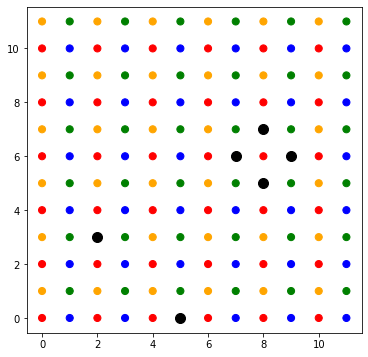

In [245]:
nodes = itertools.product(np.arange(2*m), np.arange(2*ell))

gen_qbts = qbts[np.where(Hx[22])[0]]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=50, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=100, c='k')

(array([0.25      , 0.        , 0.        , 0.        , 0.16666667,
        0.        , 0.        , 0.        , 0.        , 0.47222222,
        0.        , 0.        , 0.08333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02777778]),
 array([3.88329757, 4.0882911 , 4.29328462, 4.49827815, 4.70327168,
        4.90826521, 5.11325873, 5.31825226, 5.52324579, 5.72823932,
        5.93323284, 6.13822637, 6.3432199 , 6.54821343, 6.75320695,
        6.95820048, 7.16319401, 7.36818754, 7.57318107, 7.77817459]),
 <BarContainer object of 19 artists>)

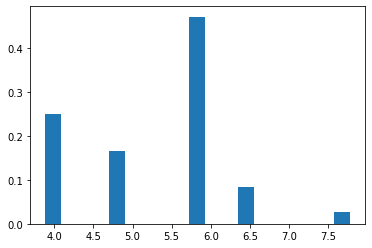

In [246]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])

bins = np.linspace(min(rs), max(rs), 20)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)

(array([0.38888889, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16666667, 0.        , 0.        ,
        0.20138889, 0.10416667, 0.        , 0.04166667, 0.02083333,
        0.06944444, 0.        , 0.        , 0.00694444]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

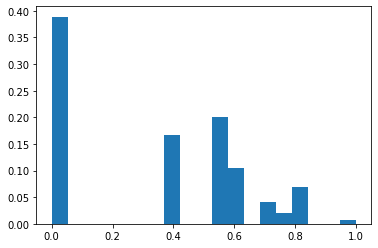

In [82]:
scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
counts, _ = np.histogram(scaled_rs, bins=bins)
counts_weighter = counts.sum()
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)

In [83]:
sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])])

0.3329678362573099

In [228]:
n = 4
for combination in itertools.product(range(1, n + 1), repeat=3):
    var1, var2, var3 = combination
    # Do something with var1, var2, and var3
    print(var1, var2, var3)

1 1 1
1 1 2
1 1 3
1 1 4
1 2 1
1 2 2
1 2 3
1 2 4
1 3 1
1 3 2
1 3 3
1 3 4
1 4 1
1 4 2
1 4 3
1 4 4
2 1 1
2 1 2
2 1 3
2 1 4
2 2 1
2 2 2
2 2 3
2 2 4
2 3 1
2 3 2
2 3 3
2 3 4
2 4 1
2 4 2
2 4 3
2 4 4
3 1 1
3 1 2
3 1 3
3 1 4
3 2 1
3 2 2
3 2 3
3 2 4
3 3 1
3 3 2
3 3 3
3 3 4
3 4 1
3 4 2
3 4 3
3 4 4
4 1 1
4 1 2
4 1 3
4 1 4
4 2 1
4 2 2
4 2 3
4 2 4
4 3 1
4 3 2
4 3 3
4 3 4
4 4 1
4 4 2
4 4 3
4 4 4
